In [1]:

import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from fastprogress import progress_bar
from glob import glob

In [17]:
#path = Path.home()/'data'/'tiny-imagenet-200'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'
bs = 512
# bs = 32
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [18]:
tfms = nn.Sequential(T.Pad(8), T.RandomCrop(64), T.RandomHorizontalFlip())

In [19]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

In [20]:
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32))[None]
    x = F.interpolate(x, scale_factor=2)
    if erase: x = rand_erase(x)
    return x[0]

In [21]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [22]:
xb,yb = next(iter(dls.train))

/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

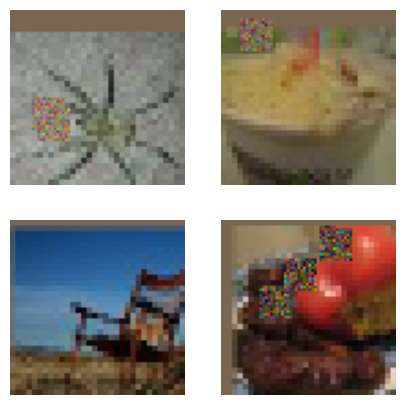

In [23]:
show_images(denorm(xb[:4]), imsize=2.5)

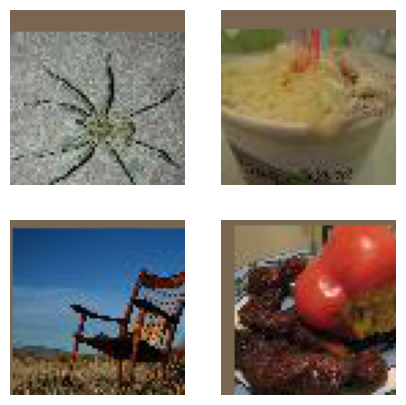

In [24]:
show_images(denorm(yb[:4]), imsize=2.5)
     